# This notebook is prepared on Kaggle kernel for submission to the AIPlanet / Dphi practice competition on the following link: https://aiplanet.com/challenges/data-sprint-97-card-classification/312/overview/about

# Import the required packages

In [10]:
import os
import random
import numpy as np
import tensorflow as tf
# from keras import backend as K
# os.environ['PYTHONHASHSEED'] = str(1)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# random.seed(1)
# np.random.seed(1)
# tf.random.set_seed(1)
# tf.compat.v1.set_random_seed(1)
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import L1, L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
# import tensorflow_addons as tfa
import gc
from PIL import Image

# Path names

In [3]:
train_image_path = '../input/playing-card-images-53-classes-1000-train-500-test/train'
test_image_path = '../input/playing-card-images-53-classes-1000-train-500-test/test'
train_csv_path = '../input/playing-card-images-53-classes-1000-train-500-test/Training_set.csv'
test_csv_path = '../input/playing-card-images-53-classes-1000-train-500-test/Testing_set.csv'

# Plot a few images of train data

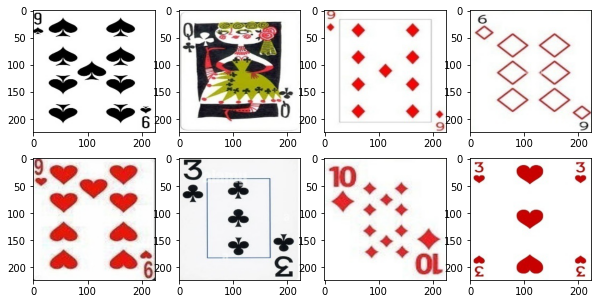

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
src_path = train_image_path
sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:8])):
    plt.subplot(2,4,e+1)
    img = plt.imread(os.path.join(src_path,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
img = plt.imread('../input/playing-card-images-53-classes-1000-train-500-test/train/Image_1002.jpg')
img.shape

In [ ]:
src_path = train_image_path
sub_class = os.listdir(src_path)
for batch in range(0,500,32):
#     batch=4
    start = batch
    end = start+32
    fig = plt.figure(figsize=(20,10))
    for e in range(start, start+32):
        plt.subplot(4,8,e%32+1)
        img = plt.imread(os.path.join(src_path,sub_class[e]))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
    gc.collect()

# Crop the corners of all images

In [ ]:
im = Image.open(r"../input/playing-card-images-53-classes-1000-train-500-test/train/Image_4.jpg")
im1 = im.crop((1, 1, 40, 60))
im1.save('/kaggle/working/test1.jpg')
img = plt.imread('./test1.jpg')
plt.imshow(img)

# Crop all training data

In [ ]:
if not os.path.exists('/kaggle/working/train'):
    os.mkdir('/kaggle/working/train')
for filename in os.listdir(train_image_path):
    im = Image.open(train_image_path+'/'+filename)
    im1 = im.crop((1, 1, 60, 80))
    im1.save('/kaggle/working/train/'+filename)

In [ ]:
# os.listdir('/kaggle/working/train')

In [ ]:
print('/kaggle/working/train/'+filename)

# Crop all test data

In [ ]:
if not os.path.exists('/kaggle/working/test'):
    os.mkdir('/kaggle/working/test')
for filename in os.listdir(test_image_path):
    im = Image.open(test_image_path+'/'+filename)
    im1 = im.crop((1, 1, 60, 80))
    im1.save('/kaggle/working/test/'+filename)

In [ ]:
# os.listdir('/kaggle/working/test')

# New created file paths

In [ ]:
train_image_path = '/kaggle/working/train/'
test_image_path = '/kaggle/working/test/'

In [ ]:
src_path = train_image_path
sub_class = os.listdir(src_path)
for batch in range(100,200,32):
#     batch=4
    start = batch
    end = start+32
    fig = plt.figure(figsize=(20,10))
    for e in range(start, start+32):
        plt.subplot(4,8,e%32+1)
        img = plt.imread(os.path.join(src_path,sub_class[e]))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
    gc.collect()

# Load the Pandas DataFrames

In [4]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [5]:
train_df.shape, test_df.shape

((4776, 2), (2048, 1))

In [6]:
train_df.head()

,filename,label
0,Image_1.jpg,six of clubs
1,Image_2.jpg,queen of hearts
2,Image_3.jpg,seven of diamonds
3,Image_4.jpg,six of spades
4,Image_5.jpg,eight of spades


In [9]:
# import seaborn as sns
# plt.figure(figsize=(8,20))
# sns.countplot(data=train_df, y='label', orient='h')
# plt.show()

In [8]:
# from sklearn.utils import class_weight
# class_weights = list(class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label']))
# class_weights

In [10]:
# np.unique(train_df['label'])

In [11]:
# weights = dict(zip(train_generator.class_indices.values(), class_weights))
# weights

In [12]:
# train_generator.class_indices.values()

# Initialize Keras’ ImageDataGenerator class

In [101]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=30,
        zoom_range=0.2,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode="nearest",
#         zca_whitening=True,
    brightness_range=[0.6,1.4],
        validation_split=0.2)

test_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=30,
        zoom_range=0.2,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode="nearest",
    brightness_range=[0.6,1.4],
)

# Initialize training, validation and testing generators

In [102]:
batch_size = 32
target_size = 224
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_path,
    x_col="filename",
    y_col="label",
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_path,
    x_col="filename",
    y_col="label",
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_image_path,
    x_col="filename",
    target_size=(target_size, target_size),
    batch_size=1,
    class_mode=None,
    shuffle=False,
)

Found 3821 validated image filenames belonging to 53 classes.
Found 955 validated image filenames belonging to 53 classes.
Found 2048 validated image filenames.


# Create class dict for later use

In [9]:
# print(train_generator.class_indices)
class_names = {idx:name for name, idx in train_generator.class_indices.items()}
# print(class_names)

# Plotting Functions

In [10]:
start = 1
def plot_loss(history_dict):
    key1 = list(history_dict.keys())[0]
    key2 = list(history_dict.keys())[2]
    loss_values = history_dict[key1][start:]
    val_loss_values=history_dict[key2][start:]
    plt.plot(loss_values,'b-',label=key1)
    plt.plot(val_loss_values,'r--',label=key2)
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()
    print(key1, ': ', history_dict[key1][-1], key2,': ', history_dict[key2][-1])

def plot_metric(history_dict):
    key1 = list(history_dict.keys())[1]
    key2 = list(history_dict.keys())[3]
    metric_values = history_dict[key1][start:]
    val_metric_values=history_dict[key2][start:]
    plt.plot(metric_values,'b-',label=key1)
    plt.plot(val_metric_values,'r--',label=key2)
    plt.title('Training vs Validation Metric')
    plt.legend()
    plt.show()
    print(key1, ': ', history_dict[key1][-1], key2,': ', history_dict[key2][-1])

# Experiments on MobileNet

In [103]:
pretrained_model = keras.applications.MobileNet(
                                            include_top=False,
                                            weights="imagenet",
                                            input_shape=(target_size,target_size,3),
                                            pooling=None,
                                            classes=53,
#                                             classifier_activation="softmax",
                                        )

In [104]:
# del model
# gc.collect()

In [105]:
model = Sequential()
for layer in pretrained_model.layers:
    layer.trainable=True
model.add(pretrained_model)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
# model.add(Dense(1024, activation='relu', ))#kernel_initializer='he_normal'
# model.add(BatchNormalization())
# model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(Dense(53, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
tqdm_call = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1, mode="min", cooldown=1, min_lr=0)
stop_call = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint_filepath = '/kaggle/working/model'
cp_call = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', 
                          save_best_only=True)
print(round(model.optimizer.lr.numpy(), 5))
history = model.fit(train_generator, validation_data = valid_generator,
#           steps_per_epoch = train_generator.n//train_generator.batch_size,
#           validation_steps = valid_generator.n//valid_generator.batch_size,
          epochs=100, class_weight=None, callbacks=[lr_call, stop_call, cp_call])#
print(round(model.optimizer.lr.numpy(), 5))
plot_loss(history.history)
plt.show()
plot_metric(history.history)
plt.show()

0.001
Epoch 1/100
120/120 [==============================] - 72s 573ms/step - loss: 4.3180 - accuracy: 0.0960 - val_loss: 4.6358 - val_accuracy: 0.0838
Epoch 2/100
120/120 [==============================] - 68s 570ms/step - loss: 3.1633 - accuracy: 0.1929 - val_loss: 2.5457 - val_accuracy: 0.2827
Epoch 3/100
120/120 [==============================] - 68s 564ms/step - loss: 2.6339 - accuracy: 0.2868 - val_loss: 2.0970 - val_accuracy: 0.4241
Epoch 4/100
120/120 [==============================] - 67s 560ms/step - loss: 2.1795 - accuracy: 0.3892 - val_loss: 1.7335 - val_accuracy: 0.5445
Epoch 5/100
120/120 [==============================] - 68s 566ms/step - loss: 1.8153 - accuracy: 0.5054 - val_loss: 1.5548 - val_accuracy: 0.5728
Epoch 6/100
120/120 [==============================] - 68s 563ms/step - loss: 1.5584 - accuracy: 0.5671 - val_loss: 1.7537 - val_accuracy: 0.5780
Epoch 7/100
120/120 [==============================] - 68s 563ms/step - loss: 1.4077 - accuracy: 0.6213 - val_loss: 1.

KeyboardInterrupt: 

In [94]:
# model.load_weights(checkpoint_filepath)
model.evaluate(valid_generator)

38/38 [==============================] - 3s 75ms/step - loss: 0.1144 - accuracy: 0.9807


[0.11436989903450012, 0.980737030506134]

In [22]:
# model.fit(train_generator, validation_data = valid_generator, epochs=100, class_weight=None, callbacks=[lr_call,stop_call])#

In [95]:
preds = model.predict(test_generator, steps = len(test_generator.filenames))
preds = preds.argmax(axis=-1)

In [96]:
test_df['label_num']=preds
display(test_df.head(2))
test_df['label'] = test_df.label_num.map(class_names)
display(test_df.head(2))
test_df[['filename','label']].to_csv('sub21.csv', index=False)
!head sub21.csv

,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


filename,label
Image_1.jpg,queen of spades
Image_2.jpg,ace of spades
Image_3.jpg,eight of diamonds
Image_4.jpg,four of diamonds
Image_5.jpg,three of clubs
Image_6.jpg,four of diamonds
Image_7.jpg,jack of clubs
Image_8.jpg,jack of diamonds
Image_9.jpg,jack of clubs


# Mobilenet achieved ___% on LB: batch 32, no aug, 0.2 val split, no balancing, no freeze, dense 128, batchnorm, dropout 0.7, start lr 0.001, factor 0.1, patience 2, cooldown 2, without TTA

In [68]:
tta_steps = 10
predictions = []
for i in tqdm(range(tta_steps)):
    preds = model.predict(test_generator, steps = len(test_generator.filenames))
    predictions.append(preds)
preds = np.mean(predictions, axis=0)
preds = np.argmax(preds, axis=-1)
test_df['label_num']=preds
display(test_df.head(2))
test_df['label'] = test_df.label_num.map(class_names)
display(test_df.head(2))
test_df[['filename','label']].to_csv('sub10.csv', index=False)
!head sub10.csv

100%|██████████| 10/10 [02:04<00:00, 12.42s/it]


,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


filename,label
Image_1.jpg,queen of spades
Image_2.jpg,ace of spades
Image_3.jpg,eight of diamonds
Image_4.jpg,four of diamonds
Image_5.jpg,three of clubs
Image_6.jpg,four of diamonds
Image_7.jpg,jack of clubs
Image_8.jpg,jack of diamonds
Image_9.jpg,jack of clubs


# Mobilenet achieved ____% on LB: batch 32, brightness 0.5-1.5, rot 0.3, 0.1 val split, no balancing, no freeze, dense 128, batchnorm, dropout 0.7, start lr 0.001, factor 0.1, patience 1, cooldown 0, with TTA

# Mobilenet achieved 95.73 without TTA

In [12]:
pretrained_model = keras.applications.MobileNet(
                                            include_top=False,
                                            weights="imagenet",
                                            input_shape=(target_size,target_size,3),
                                            pooling=None,
                                            classes=53,
#                                             classifier_activation="softmax",
                                        )

In [15]:
# del model
# gc.collect()

0.001
Epoch 1/100
120/120 [==============================] - 23s 173ms/step - loss: 1.0036 - accuracy: 0.7891 - val_loss: 0.3581 - val_accuracy: 0.9246
Epoch 2/100
120/120 [==============================] - 20s 166ms/step - loss: 0.1575 - accuracy: 0.9825 - val_loss: 0.3249 - val_accuracy: 0.9257
Epoch 3/100
120/120 [==============================] - 20s 169ms/step - loss: 0.1136 - accuracy: 0.9843 - val_loss: 0.3065 - val_accuracy: 0.9330
Epoch 4/100
120/120 [==============================] - 20s 166ms/step - loss: 0.0606 - accuracy: 0.9945 - val_loss: 0.3440 - val_accuracy: 0.9309
Epoch 5/100
120/120 [==============================] - 20s 170ms/step - loss: 0.0474 - accuracy: 0.9945 - val_loss: 0.3311 - val_accuracy: 0.9267

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/100
120/120 [==============================] - 21s 171ms/step - loss: 0.0526 - accuracy: 0.9932 - val_loss: 0.2706 - val_accuracy: 0.9424
Epoch 7/100
120/120 [===============

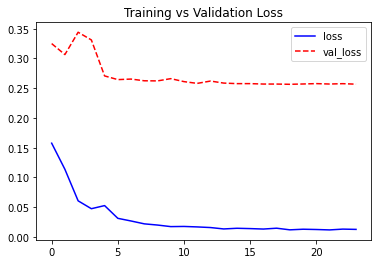

loss :  0.012636873871088028 val_loss :  0.2567182183265686


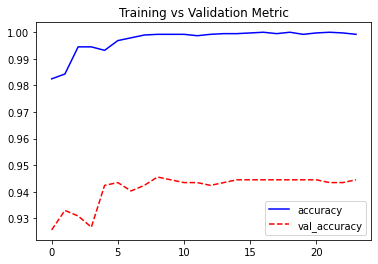

accuracy :  0.9992148876190186 val_accuracy :  0.944502592086792


In [20]:
model = Sequential()
for layer in pretrained_model.layers:
    layer.trainable=True
model.add(pretrained_model)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.6))
# model.add(Dense(128, activation='relu', ))#kernel_initializer='he_normal'
# model.add(BatchNormalization())
# model.add(Dropout(0.6))
model.add(Dense(128, activation='relu', ))#kernel_initializer='he_normal'
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(53, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
tqdm_call = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1, mode="min", cooldown=1, min_lr=0)
stop_call = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
print(round(model.optimizer.lr.numpy(), 5))
history = model.fit(train_generator, validation_data = valid_generator,
#           steps_per_epoch = train_generator.n//train_generator.batch_size,
#           validation_steps = valid_generator.n//valid_generator.batch_size,
          epochs=100, class_weight=None, callbacks=[
              #tqdm_call, 
              lr_call, 
              stop_call
          ])#
print(round(model.optimizer.lr.numpy(), 5))
plot_loss(history.history)
plt.show()
plot_metric(history.history)
plt.show()

In [22]:
# model.fit(train_generator, validation_data = valid_generator, epochs=100, class_weight=None, callbacks=[lr_call,stop_call])#

In [21]:
preds = model.predict(test_generator, steps = len(test_generator.filenames))
preds = preds.argmax(axis=-1)

In [22]:
test_df['label_num']=preds
display(test_df.head(2))
test_df['label'] = test_df.label_num.map(class_names)
display(test_df.head(2))
test_df[['filename','label']].to_csv('sub11.csv', index=False)
!head sub11.csv

,filename,label_num
0,Image_1.jpg,32
1,Image_2.jpg,3


,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


filename,label
Image_1.jpg,queen of spades
Image_2.jpg,ace of spades
Image_3.jpg,eight of diamonds
Image_4.jpg,four of diamonds
Image_5.jpg,three of clubs
Image_6.jpg,four of diamonds
Image_7.jpg,jack of clubs
Image_8.jpg,jack of diamonds
Image_9.jpg,queen of spades


# Mobilenet achieved 95.73% on LB: batch 32, no aug, 0.2 val split, no balancing, no freeze, dense 128, batchnorm, dropout 0.7, start lr 0.001, factor 0.1, patience 2, cooldown 2, without TTA

In [68]:
tta_steps = 10
predictions = []
for i in tqdm(range(tta_steps)):
    preds = model.predict(test_generator, steps = len(test_generator.filenames))
    predictions.append(preds)
preds = np.mean(predictions, axis=0)
preds = np.argmax(preds, axis=-1)
test_df['label_num']=preds
display(test_df.head(2))
test_df['label'] = test_df.label_num.map(class_names)
display(test_df.head(2))
test_df[['filename','label']].to_csv('sub10.csv', index=False)
!head sub10.csv

100%|██████████| 10/10 [02:04<00:00, 12.42s/it]


,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


filename,label
Image_1.jpg,queen of spades
Image_2.jpg,ace of spades
Image_3.jpg,eight of diamonds
Image_4.jpg,four of diamonds
Image_5.jpg,three of clubs
Image_6.jpg,four of diamonds
Image_7.jpg,jack of clubs
Image_8.jpg,jack of diamonds
Image_9.jpg,jack of clubs


# Mobilenet achieved ____% on LB: batch 32, brightness 0.5-1.5, rot 0.3, 0.1 val split, no balancing, no freeze, dense 128, batchnorm, dropout 0.7, start lr 0.001, factor 0.1, patience 1, cooldown 0, with TTA

# Mobilenet achieved 93.77 with TTA

In [44]:
pretrained_model = keras.applications.MobileNet(
                                            include_top=False,
                                            weights="imagenet",
                                            input_shape=(target_size,target_size,3),
                                            pooling=None,
                                            classes=53,
#                                             classifier_activation="softmax",
                                        )

In [84]:
# del model
# gc.collect()

16873

0.001
Epoch 1/100
135/135 [==============================] - 27s 178ms/step - loss: 3.1039 - accuracy: 0.2531 - val_loss: 2.1507 - val_accuracy: 0.4172
Epoch 2/100
135/135 [==============================] - 24s 174ms/step - loss: 1.4637 - accuracy: 0.6374 - val_loss: 0.9577 - val_accuracy: 0.7589
Epoch 3/100
135/135 [==============================] - 23s 169ms/step - loss: 0.8407 - accuracy: 0.8186 - val_loss: 0.7134 - val_accuracy: 0.8281
Epoch 4/100
135/135 [==============================] - 23s 170ms/step - loss: 0.5793 - accuracy: 0.8772 - val_loss: 0.6425 - val_accuracy: 0.8365
Epoch 5/100
135/135 [==============================] - 23s 169ms/step - loss: 0.4326 - accuracy: 0.9074 - val_loss: 0.4591 - val_accuracy: 0.8868
Epoch 6/100
135/135 [==============================] - 24s 173ms/step - loss: 0.3342 - accuracy: 0.9300 - val_loss: 0.6061 - val_accuracy: 0.8323
Epoch 7/100
135/135 [==============================] - 23s 169ms/step - loss: 0.2791 - accuracy: 0.9418 - val_loss: 0.

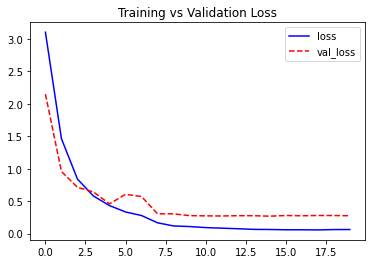

loss :  0.06328046321868896 val_loss :  0.27535906434059143


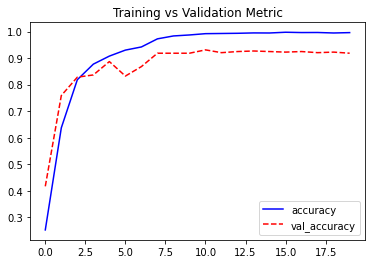

accuracy :  0.9958129525184631 val_accuracy :  0.9182389974594116


In [45]:
model = Sequential()
for layer in pretrained_model.layers:
    layer.trainable=True
model.add(pretrained_model)
model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', ))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(53, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
tqdm_call = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1, mode="min", cooldown=1, min_lr=0)
stop_call = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
print(round(model.optimizer.lr.numpy(), 5))
history = model.fit(train_generator, validation_data = valid_generator,
#           steps_per_epoch = train_generator.n//train_generator.batch_size,
#           validation_steps = valid_generator.n//valid_generator.batch_size,
          epochs=100, class_weight=None, callbacks=[
              #tqdm_call, 
              lr_call, 
              stop_call
          ])#
print(round(model.optimizer.lr.numpy(), 5))
plot_loss(history.history)
plt.show()
plot_metric(history.history)
plt.show()

In [22]:
# model.fit(train_generator, validation_data = valid_generator, epochs=100, class_weight=None, callbacks=[lr_call,stop_call])#

In [46]:
preds = model.predict(test_generator, steps = len(test_generator.filenames))
preds = preds.argmax(axis=-1)

In [47]:
test_df['label_num']=preds
display(test_df.head(2))
test_df['label'] = test_df.label_num.map(class_names)
display(test_df.head(2))
test_df[['filename','label']].to_csv('sub7.csv', index=False)
!head sub7.csv

,filename,label_num
0,Image_1.jpg,32
1,Image_2.jpg,3


,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


filename,label
Image_1.jpg,queen of spades
Image_2.jpg,ace of spades
Image_3.jpg,eight of diamonds
Image_4.jpg,four of diamonds
Image_5.jpg,three of clubs
Image_6.jpg,four of diamonds
Image_7.jpg,jack of clubs
Image_8.jpg,jack of diamonds
Image_9.jpg,jack of clubs


# Mobilenet achieved 93.65% on LB: batch 32, brightness 0.5-1.5, 0.1 val split, no balancing, no freeze, dense 128, batchnorm, dropout 0.7, start lr 0.001, factor 0.1, patience 2, cooldown 1, without TTA

In [48]:
tta_steps = 10
predictions = []
for i in tqdm(range(tta_steps)):
    preds = model.predict(test_generator, steps = len(test_generator.filenames))
    predictions.append(preds)
preds = np.mean(predictions, axis=0)
preds = np.argmax(preds, axis=-1)
test_df['label_num']=preds
display(test_df.head(2))
test_df['label'] = test_df.label_num.map(class_names)
display(test_df.head(2))
test_df[['filename','label']].to_csv('sub8.csv', index=False)
!head sub8.csv

100%|██████████| 10/10 [02:32<00:00, 15.23s/it]


,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


filename,label
Image_1.jpg,queen of spades
Image_2.jpg,ace of spades
Image_3.jpg,eight of diamonds
Image_4.jpg,four of diamonds
Image_5.jpg,three of clubs
Image_6.jpg,four of diamonds
Image_7.jpg,jack of clubs
Image_8.jpg,jack of diamonds
Image_9.jpg,jack of clubs


# Mobilenet achieved 93.77% on LB: batch 32, brightness 0.5-1.5, 0.1 val split, no balancing, no freeze, dense 128, batchnorm, dropout 0.7, start lr 0.001, factor 0.1, patience 2, cooldown 1, with TTA

# (3) Pretrained model MobileNet

In [27]:
pretrained_model = keras.applications.MobileNet(
                                            include_top=False,
                                            weights="imagenet",
                                            input_shape=(target_size,target_size,3),
                                            pooling=None,
                                            classes=53,
#                                             classifier_activation="softmax",
                                        )

17235968/17225924 [==============================] - 0s 0us/step


0.001
Epoch 1/10
135/135 [==============================] - 24s 164ms/step - loss: 2.7084 - accuracy: 0.3026 - val_loss: 2.4390 - val_accuracy: 0.4067
Epoch 2/10
135/135 [==============================] - 22s 160ms/step - loss: 1.8430 - accuracy: 0.5094 - val_loss: 1.5540 - val_accuracy: 0.6352
Epoch 3/10
135/135 [==============================] - 22s 160ms/step - loss: 1.3876 - accuracy: 0.6097 - val_loss: 1.8272 - val_accuracy: 0.5618
Epoch 4/10
135/135 [==============================] - 22s 161ms/step - loss: 0.9714 - accuracy: 0.7306 - val_loss: 0.6044 - val_accuracy: 0.8637
Epoch 5/10
135/135 [==============================] - 21s 158ms/step - loss: 0.8009 - accuracy: 0.7651 - val_loss: 0.5531 - val_accuracy: 0.8679
Epoch 6/10
135/135 [==============================] - 22s 160ms/step - loss: 0.6750 - accuracy: 0.7937 - val_loss: 0.5255 - val_accuracy: 0.8847
Epoch 7/10
135/135 [==============================] - 22s 160ms/step - loss: 0.5888 - accuracy: 0.8227 - val_loss: 0.5077 - 

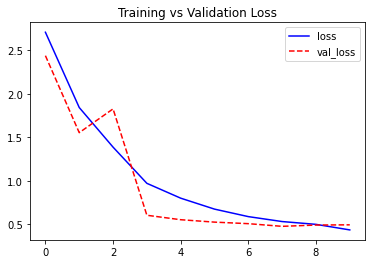

loss :  0.43591323494911194 val_loss :  0.4944334030151367


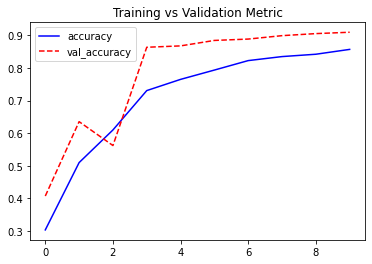

accuracy :  0.8571760654449463 val_accuracy :  0.9098532199859619


In [30]:
del model
gc.collect()
model = Sequential()
for layer in pretrained_model.layers:
    layer.trainable=True
model.add(pretrained_model)
model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(53, activation='softmax'))
# Compile the new model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', 
               metrics=['accuracy'])
tqdm_call = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=0,
    mode="min", cooldown=0, min_lr=0)
stop_call = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# Fit the model on the training dataset and check with the validation set
print(round(model.optimizer.lr.numpy(), 5))
history = model.fit(train_generator,
          validation_data = valid_generator,
#           steps_per_epoch = train_generator.n//train_generator.batch_size,
#           validation_steps = valid_generator.n//valid_generator.batch_size,
          epochs=10, class_weight=None, callbacks=[
              #tqdm_call, 
              lr_call, 
#               stop_call
          ])#
print(round(model.optimizer.lr.numpy(), 5))
# Plot the training and validation losses
plot_loss(history.history)
plt.show()
plot_metric(history.history)
plt.show()

In [31]:
preds = model.predict(test_generator, steps = len(test_generator.filenames))
preds

array([[1.48155620e-11, 1.77658777e-09, 1.24403057e-08, ...,
        1.15407213e-08, 2.91366764e-10, 2.03304200e-08],
       [5.14572607e-09, 8.69075312e-10, 1.90318361e-09, ...,
        3.25076544e-05, 1.10961882e-05, 1.81050927e-05],
       [1.76041339e-17, 9.73987926e-13, 5.33102089e-17, ...,
        9.36452218e-12, 1.08116641e-12, 4.13712237e-14],
       ...,
       [8.35376792e-03, 1.24806635e-01, 7.33255804e-01, ...,
        2.86589004e-02, 8.29575700e-04, 1.04722974e-03],
       [2.39894823e-11, 6.26048996e-12, 5.23325307e-11, ...,
        1.56674818e-09, 3.44435536e-10, 7.61957500e-13],
       [7.23956728e-11, 1.27808420e-14, 1.73244894e-06, ...,
        2.91336638e-12, 7.94951006e-07, 2.08148691e-07]], dtype=float32)

In [32]:
preds = preds.argmax(axis=-1)

In [33]:
test_df['label_num']=preds
display(test_df.head(2))
test_df['label'] = test_df.label_num.map(class_names)
display(test_df.head(2))
test_df[['filename','label']].to_csv('sub2.csv', index=False)
!head sub2.csv

,filename,label_num
0,Image_1.jpg,32
1,Image_2.jpg,3


,filename,label_num,label
0,Image_1.jpg,32,queen of spades
1,Image_2.jpg,3,ace of spades


head: cannot open 'sub1.csv' for reading: No such file or directory


# This achieved accuracy 90.5 on the LB

# (1) Let's use a custom CNN model

In [18]:
del model
gc.collect()

44865

1e-04
Epoch 1/2
135/135 [==============================] - 14s 101ms/step - loss: 3.5562 - accuracy: 0.1089 - val_loss: 2.7333 - val_accuracy: 0.2600
Epoch 2/2
135/135 [==============================] - 13s 99ms/step - loss: 2.2948 - accuracy: 0.3752 - val_loss: 2.0041 - val_accuracy: 0.4612
1e-04


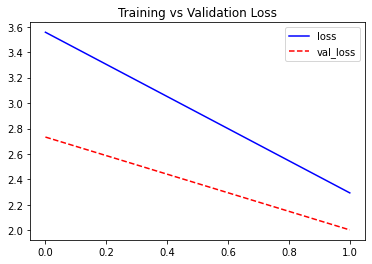

loss :  2.2948131561279297 val_loss :  2.00411057472229


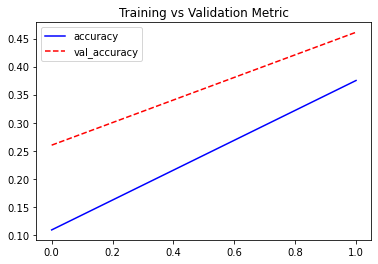

accuracy :  0.37520354986190796 val_accuracy :  0.46121594309806824


In [23]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(target_size, target_size,3)),
    MaxPool2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(53, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', 
               metrics=['accuracy'])
print(round(model.optimizer.lr.numpy(), 5))
# tqdm_call = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=0,
    mode="min", cooldown=0, min_lr=0)
stop_call = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(train_generator,
          validation_data = valid_generator,
#           steps_per_epoch = train_generator.n//train_generator.batch_size,
#           validation_steps = valid_generator.n//valid_generator.batch_size,
          epochs=2, callbacks=[
#               tqdm_call, 
#               lr_call, 
#               stop_call
          ])#
print(round(model.optimizer.lr.numpy(), 5))
# Plot the training and validation losses
plot_loss(history.history)
plt.show()
plot_metric(history.history)
plt.show()

# (2) Use pretrained model Xception from Keras library

In [24]:
pretrained_model = keras.applications.Xception(
                                            include_top=False,
                                            weights="imagenet",
                                            input_shape=(target_size,target_size,3),
                                            pooling=None,
                                            classes=53,
#                                             classifier_activation="softmax",
                                        )

83697664/83683744 [==============================] - 0s 0us/step


In [25]:
del model
gc.collect()

29455

In [26]:
model = Sequential()
# for layer in pretrained_model.layers:
#     layer.trainable=False
model.add(pretrained_model)
# model.add(Conv2D(512,3,strides=1,padding='valid',activation='relu'))
model.add(Flatten())
# model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))#, kernel_initializer='uniform')
model.add(Dropout(0.5))
model.add(Dense(53, activation='softmax'))#, kernel_initializer='orthogonal')
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', 
               metrics=['accuracy'])
# tqdm_call = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=0, mode="min", cooldown=0, min_lr=0)
stop_call = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
print(round(model.optimizer.lr.numpy(), 5))
history = model.fit(train_generator,
          validation_data = valid_generator,
#           steps_per_epoch = train_generator.n//train_generator.batch_size,
#           validation_steps = valid_generator.n//valid_generator.batch_size,
          epochs=25, callbacks=[
#               tqdm_call, 
              lr_call,  
#               stop_call,
          ])#
print(round(model.optimizer.lr.numpy(), 5))
plot_loss(history.history)
plt.show()
plot_metric(history.history)
plt.show()

0.001
Epoch 1/25
135/135 [==============================] - 60s 410ms/step - loss: 4.0122 - accuracy: 0.0281 - val_loss: 3.6380 - val_accuracy: 0.0608
Epoch 2/25
135/135 [==============================] - 53s 396ms/step - loss: 3.4968 - accuracy: 0.0982 - val_loss: 3.2795 - val_accuracy: 0.1551
Epoch 3/25
135/135 [==============================] - 54s 396ms/step - loss: 3.1128 - accuracy: 0.1752 - val_loss: 3.5522 - val_accuracy: 0.0776
Epoch 4/25
 19/135 [===>..........................] - ETA: 44s - loss: 2.8316 - accuracy: 0.2270

KeyboardInterrupt: 

### 74sec, 567ms/step, 18%, 21%
### 68sec, 537ms/step, 31%, 26%

# (4) Pretrained model ResNet50V2 from Keras library

In [16]:
pretrained_model = keras.applications.ResNet50V2(
                                            include_top=False,
                                            weights="imagenet",
                                            input_shape=(target_size,target_size,3),
                                            pooling=None,
                                            classes=53,
#                                             classifier_activation="softmax",
                                        )

94683136/94668760 [==============================] - 1s 0us/step


In [18]:
del model
gc.collect()
# Initialize a Sequential model, freeze the pretrained model layers
model = Sequential()
# for layer in pretrained_model.layers:
#     layer.trainable=False
# Now add the pretrained model, flatten the output, add one additional hidden fully connected layer, 
# and the last output layer to classify 10 categories for this problem
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(53, activation='softmax'))#, kernel_initializer='orthogonal'))
# Compile the new model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# tqdm_call = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=1, mode="min", cooldown=1, min_lr=0)
stop_call = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# Fit the model on the training dataset and check with the validation set
print(round(model.optimizer.lr.numpy(), 5))
history = model.fit(train_generator,
          validation_data = valid_generator,
#           steps_per_epoch = train_generator.n//train_generator.batch_size,
#           validation_steps = valid_generator.n//valid_generator.batch_size,
          epochs=20, callbacks=[
              #tqdm_call, 
              lr_call, stop_call])#
print(round(model.optimizer.lr.numpy(), 5))
# Plot the training and validation losses
plot_loss(history.history)
plt.show()
plot_metric(history.history)
plt.show()

0.001
Epoch 1/20
135/135 [==============================] - 30s 188ms/step - loss: 1.5577 - accuracy: 0.6134 - val_loss: 1.3724 - val_accuracy: 0.6688
Epoch 2/20
135/135 [==============================] - 25s 184ms/step - loss: 0.6330 - accuracy: 0.8293 - val_loss: 1.0678 - val_accuracy: 0.7296
Epoch 3/20
135/135 [==============================] - 25s 183ms/step - loss: 0.3385 - accuracy: 0.9079 - val_loss: 0.9649 - val_accuracy: 0.7421
Epoch 4/20
135/135 [==============================] - 25s 184ms/step - loss: 0.2216 - accuracy: 0.9402 - val_loss: 0.8694 - val_accuracy: 0.7904
Epoch 5/20
135/135 [==============================] - 25s 186ms/step - loss: 0.1194 - accuracy: 0.9716 - val_loss: 0.6944 - val_accuracy: 0.8281
Epoch 6/20
135/135 [==============================] - 24s 180ms/step - loss: 0.0792 - accuracy: 0.9828 - val_loss: 0.8702 - val_accuracy: 0.7841

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/20
135/135 [======================

KeyboardInterrupt: 

# Keras VGG19

In [ ]:
pretrained_model = keras.applications.VGG19(
                                            include_top=False,
                                            weights="imagenet",
                                            input_shape=(target_size,target_size,3),
                                            pooling=None,
                                            classes=53,
#                                             classifier_activation="softmax",
                                        )

In [ ]:
del model
gc.collect()
# Initialize a Sequential model, freeze the pretrained model layers
model = Sequential()
# for layer in pretrained_model.layers:
#     layer.trainable=False
# Now add the pretrained model, flatten the output, add one additional hidden fully connected layer, 
# and the last output layer to classify 10 categories for this problem
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(53, activation='softmax'))#, kernel_initializer='orthogonal'))
# Compile the new model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', 
               metrics=['accuracy'])
# tqdm_call = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=0, mode="min", cooldown=0, min_lr=0)
stop_call = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# Fit the model on the training dataset and check with the validation set
print(round(model.optimizer.lr.numpy(), 5))
history = model.fit(train_generator,
          validation_data = valid_generator,
          steps_per_epoch = train_generator.n//train_generator.batch_size,
          validation_steps = valid_generator.n//valid_generator.batch_size,
          epochs=20, callbacks=[
              #tqdm_call, 
              lr_call, stop_call])#
print(round(model.optimizer.lr.numpy(), 5))
# Plot the training and validation losses
plot_loss(history.history)
plt.show()
plot_metric(history.history)
plt.show()

# Evaluate model performance

In [ ]:
score = model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
tta_steps = 10
predictions = []
for i in tqdm(range(tta_steps)):
    preds = model.predict(test_generator, steps = len(test_generator.filenames))
    predictions.append(preds)
preds = np.mean(predictions, axis=0)
preds = np.argmax(preds, axis=-1)
test_df['label_num']=preds
display(test_df.head(2))
test_df['label'] = test_df.label_num.map(class_names)
display(test_df.head(2))
test_df[['filename','label']].to_csv('sub17.csv', index=False)
!head sub17.csv

# Make predictions on test data using Keras’ predict

In [ ]:
# Class probabilities
preds = model.predict(test_generator, steps = len(test_generator.filenames))
# print('Class Probabilities:', preds[:5])
# Class labels
preds = preds.argmax(axis=-1)
# print('Class Labels:', preds[:5])
# Add the predictions to the test dataframe
test_df['label_num']=preds
display(test_df.head(2))
# Add the label names to the test dataframe
test_df['label'] = test_df.label_num.map(class_names)
display(test_df.head(2))

# Create the final submission file

In [ ]:
test_df[['filename','label']].to_csv('sub6.csv', index=False)
# Check the submission file before uploading
!head sub6.csv

# On the DPhi leaderboard it got an accuracy score of ___%

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_datagen.flow(x_val, batch_size=bs, shuffle=False), steps = len(x_val)/bs)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

np.mean(np.equal(np.argmax(y_val, axis=-1), np.argmax(pred, axis=-1)))

In [ ]:
checkpoint_filepath = '/kaggle/working/model2'
cp_call = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='max', 
                          save_best_only=True)
# model.load_weights(checkpoint_filepath)
